# Tutorial Content

This notebook will walk you through steps to read in and organize velocity data in a raster format using xarray and rioxarray tools

First, lets install the python libraries that were listed on the [Software](software.ipynb) page:

In [7]:
import geopandas as gpd
import os
import numpy as np
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
from geocube.api.core import make_geocube

In [8]:
gen_path = '/Users/emmamarshall/Desktop/phd_research/siparcs/'

The velocity data we are using is broken into individual velocity components. That means that for the same spatial footprint, we have a file containing ice movement in the x direction and a file containing ice movement in the y direction. We need information from both of these files so we write a function to bring both files into the jupyter notebook, then organize them so that we can see the movement of ice in both the x and y directions as well as the magnitude of the ice velocity (speed). 



In [12]:
def components_to_speed(vx_path, vy_path):
    '''this function reads in x,y components of velocity, generates speed variable. return xarray
    dataset w/ x,y, speed variables. function will break if vx,vy objects don"t have same x,y coords'''
    
    vy_da = rxr.open_rasterio(vy_path, masked=False).squeeze()
    vx_da = rxr.open_rasterio(vx_path, masked=False).squeeze()
    
    ds_gen = xr.Dataset()
    ds_gen['vx'] = vx_da
    ds_gen['vy'] = vy_da
    sp = np.sqrt((ds_gen['vx'].data**2) + ds_gen['vy'].data**2)
    ds_gen['sp'] = (['x','y'], sp.T)
    
    return ds_gen

Let's break down what exactly the above function is doing:

First, we see that it takes two inputs: vx_path and vy_path. These paths point to where on our computer the different files are stored. 

In the first two lines of the function we use rioxarray to read in the x- and the y-component files as **xarray.DataArrays**

After that, we initialize a new object, *ds_gen*, which is a **xarray.DataSet**. We then add a variable to ds_gen called 'vx' and assign the vx_da object to that variable. We do the same for vx_da. Now, we have made a dataset that is composed of the two data arrays that we read in from file. 

We are also interested in speed, so we take the equation for computing magnitude of velocity and add a third variable (DataArray) to our Dataset. 

This will add a variable defined by the equation:

            vv = (vx^2 + vy^2)^1/2

Let's execute the function and take a look at the object it returns

First, define the inputs to your function. These are the paths to the x and the y data on your computer:

In [16]:
n45_vy_path = gen_path + '/mynewbook/gardner_data/N45_0240m_vy.tiff'
n45_vx_path = gen_path + 'mynewbook/gardner_data/N45_0240m_vx.tiff'


And run the function: 

In [18]:
ds_45n = components_to_speed(n45_vx_path, n45_vy_path)


Let's explore this object a bit:

In [19]:
ds_45n

<xarray.Dataset>
Dimensions:      (x: 4440, y: 27072)
Coordinates:
    band         int64 1
  * x            (x) float64 -3.253e+04 -3.229e+04 ... 1.033e+06 1.033e+06
  * y            (y) float64 6.297e+06 6.297e+06 ... -1.993e+05 -1.996e+05
    spatial_ref  int64 0
Data variables:
    vx           (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    vy           (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    sp           (x, y) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan

In [23]:
#read in vector data 
se_asia = gpd.read_file('/Users/emmamarshall/Desktop/phd_research/nisar_prepwork/glacier_files/rgi_all47/15_rgi60_SouthAsiaEast.shp')
#sw_asia = gpd.read_file('/Users/emmamarshall/Desktop/phd_research/nisar_prepwork/rgi_1km/sw_asia_1km.shp')
#c_asia = gpd.read_file('/Users/emmamarshall/Desktop/phd_research/nisar_prepwork/rgi_1km/central_asia_1km.shp') 

#se_asia_path = '/Users/emmamarshall/Desktop/phd_research/nisar_prepwork/rgi_1km/se_asia_1km.shp'
#sw_asia_path = '/Users/emmamarshall/Desktop/phd_research/nisar_prepwork/rgi_1km/sw_asia_1km.shp'
#c_asia_path = '/Users/emmamarshall/Desktop/phd_research/nisar_prepwork/rgi_1km/central_asia_1km.shp'




In [24]:
se_asia

,geometry
0,"POLYGON ((102.03759 29.93828, 102.03759 29.938..."
1,"POLYGON ((102.04195 29.99030, 102.04197 29.990..."
2,"POLYGON ((102.03710 29.99774, 102.03719 29.998..."
3,"POLYGON ((102.04309 29.95992, 102.04315 29.960..."
4,"POLYGON ((102.04765 30.02514, 102.04741 30.024..."
...,...
13114,"POLYGON ((81.98085 30.33985, 81.98095 30.33949..."
13115,"POLYGON ((82.00100 30.33999, 82.00129 30.33994..."
13116,"POLYGON ((81.34247 30.45299, 81.34257 30.45268..."
13117,"POLYGON ((81.36115 30.45285, 81.36129 30.45300..."


In [11]:
#take first 100 glaciers
#se_asia_100 = se_asia.iloc[:100,:]

In [12]:
def rasterize_vector(gpdf, utm_code, raster_obj): 
    
    #read in gpdf from shp file
    #gpdf = gpd.read_file(vector_path)
    #project to local utm
    gpdf_utm = gpdf.to_crs(f'EPSG:{utm_code}')
    #use index as a unique key for each glacier
    gpdf_utm['Integer_ID'] = gpdf_utm.index.astype(int)
    #print(gpdf_utm['Integer_ID'])
    
    #rasterize glacier vector by unique id 

    out_grid = make_geocube(
            vector_data = gpdf_utm,
            measurements = ['Integer_ID'],
            like = raster_obj['sp'] #need to specify a var here, not sure best way to do that
            )
    
    #now merge the rasterized vector and the original raster togehter into a geocube
    out_grid['speed'] = (raster_obj.dims, raster_obj.sp.values, raster_obj.attrs, raster_obj.encoding)
    
    #now, get velocity statistics of each 'region' (integer) using the mask
    #grouped_ID = out_grid.drop('spatial_ref').groupby(out_grid.Integer_ID)

    #compute zonal stats groupedd by ID
    #grid_mean_sp = grouped_ID.mean().rename({'speed': 'speed_mean'})
    #grid_min_sp = grouped_ID.min().rename({'speed': 'speed_min'})
    #grid_max_sp = grouped_ID.max().rename({'speed': 'speed_max'})
    #grid_std_sp = grouped_ID.max().rename({'speed': 'speed_std'})
    
    #merge each zonal stat xr obj into a single xr obj, convert to pandas df
    #zonal_stats = xr.merge([grid_mean_sp, grid_min_sp, grid_max_sp, grid_std_sp]).to_dataframe()
    #zonal_stats = zonal_stats.reset_index()
    
   # return zonal_stats
    return out_grid

In [13]:
rasterize_vector_seasia_100 = rasterize_vector(se_asia_100, 32645, ds_45n)
rasterize_vector_seasia_100

<xarray.Dataset>
Dimensions:      (y: 27072, x: 4440)
Coordinates:
  * y            (y) float64 6.297e+06 6.297e+06 ... -1.993e+05 -1.996e+05
  * x            (x) float64 -3.253e+04 -3.229e+04 ... 1.033e+06 1.033e+06
    spatial_ref  int64 0
Data variables:
    Integer_ID   (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    speed        (x, y) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan

In [19]:
#rasterize_vector_seasia_100.plot.scatter(x='Integer_ID', y='speed',c='darkblue')
se_asia

,geometry
0,"POLYGON ((102.05137 30.00914, 102.05190 30.008..."
1,"POLYGON ((99.64363 29.87340, 99.64363 29.87345..."
2,"POLYGON ((99.64122 29.90269, 99.64084 29.90269..."
3,"POLYGON ((99.65591 29.91251, 99.65623 29.91244..."
4,"POLYGON ((99.61278 29.80515, 99.61278 29.80478..."
...,...
2735,"POLYGON ((80.22633 30.57971, 80.22628 30.57977..."
2736,"POLYGON ((79.43866 31.06966, 79.43939 31.06912..."
2737,"POLYGON ((81.98085 30.33985, 81.98095 30.33949..."
2738,"POLYGON ((82.00100 30.33999, 82.00129 30.33994..."


KeyError: 'Area'

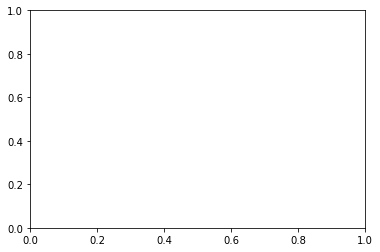

In [14]:
#project to utm
se_asia_utm = se_asia.to_crs('EPSG:32645')
#make a col in df that is a unique integer ID (from index) for each glacier
se_asia_utm['Integer_ID'] = se_asia_utm.index.astype(int)
#double checking that all glaciers are assigned an ID
se_asia_utm.plot.scatter(x='Integer_ID', y='Area')

In [19]:
#rasterize glacier vector by unique id 
#
out_grid_se_asia = make_geocube(
            vector_data = se_asia_utm,
            measurements = ['Integer_ID'],
            like = ds_45n['sp']
)

In [20]:
#now merge the rasterized vector and the original raster togehter into a geocube
out_grid_se_asia['speed'] = (ds_45n.dims, ds_45n.sp.values, ds_45n.attrs, ds_45n.encoding)
out_grid_se_asia

<xarray.Dataset>
Dimensions:      (y: 27072, x: 4440)
Coordinates:
  * y            (y) float64 6.297e+06 6.297e+06 ... -1.993e+05 -1.996e+05
  * x            (x) float64 -3.253e+04 -3.229e+04 ... 1.033e+06 1.033e+06
    spatial_ref  int64 0
Data variables:
    Integer_ID   (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    speed        (x, y) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan

In [21]:
#trying to figure out why 1300 glaciers or so get dropped
print(len(out_grid_se_asia.Integer_ID))

27072


In [22]:
#now, get velocity statistics of each 'region' (integer) using the mask
grouped_ID = out_grid_se_asia.drop('spatial_ref').groupby(out_grid_se_asia.Integer_ID)
grouped_ID

DatasetGroupBy, grouped over 'Integer_ID'
1340 groups with labels 248.0, 249.0, ..., 2.738e+03.

In [23]:
grid_mean_sp = grouped_ID.mean().rename({'speed': 'speed_mean'})
grid_median_sp = grouped_ID.median().rename({'speed': 'speed_median'})
grid_min_sp = grouped_ID.min().rename({'speed': 'speed_min'})
grid_max_sp = grouped_ID.max().rename({'speed': 'speed_max'})
grid_std_sp = grouped_ID.max().rename({'speed': 'speed_std'})

In [24]:
zonal_stats = xr.merge([grid_mean_sp, grid_median_sp, grid_min_sp, grid_max_sp, grid_std_sp]).to_dataframe()
zonal_stats = zonal_stats.reset_index()
zonal_stats

,Integer_ID,speed_mean,spatial_ref,speed_median,speed_min,speed_max,speed_std
0,248.0,14.529323,0,4.284127,0.268140,85.758003,85.758003
1,249.0,0.820514,0,0.763270,0.147464,2.407174,2.407174
2,250.0,3.385211,0,3.357724,0.139246,8.420528,8.420528
3,251.0,3.185188,0,2.607560,0.136739,9.884713,9.884713
4,252.0,1.109952,0,0.804390,0.186464,3.140323,3.140323
...,...,...,...,...,...,...,...
1335,2209.0,1.090179,0,1.076497,0.069885,4.057207,4.057207
1336,2210.0,11.063942,0,8.688779,0.106999,33.059551,33.059551
1337,2211.0,0.807759,0,0.611025,0.157515,2.715099,2.715099
1338,2737.0,0.854855,0,0.733067,0.222202,2.046064,2.046064


In [25]:
#now, trying to merge zonal stats df back with original glacier df on integer_ID col
se_asia_glacier_data = se_asia_utm.merge(zonal_stats, on='Integer_ID')


<AxesSubplot:xlabel='Integer_ID', ylabel='speed_mean'>

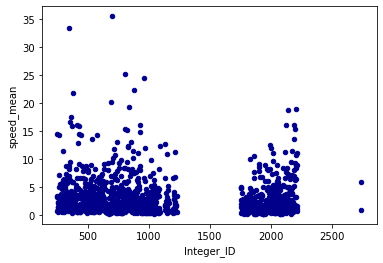

In [26]:
zonal_stats['speed_mean']

fig, ax = plt.subplots()
se_asia_glacier_data.plot.scatter(x='Integer_ID',y = 'speed_mean', c = 'darkblue', ax=ax)


In [27]:
zonal_stats['speed_mean'].min()

0.21297143

<AxesSubplot:>

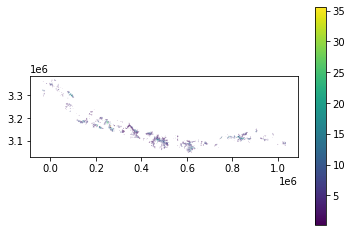

In [28]:
se_asia_glacier_data.plot(column='speed_mean', legend=True)